<a href="https://colab.research.google.com/github/madelinefuentes/face-expression-recognition/blob/master/keras_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Facial Expression Recognition Using Keras Transfer Learning

The purpose of this notebook is to demonstrate the results of using a pretrained model to train on images of faces in order to detect emotion. 

The dataset used comes from a kaggle competition (https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data).

Here is the paper associated with the challenge: https://arxiv.org/pdf/1307.0414.pdf

The train and test dataset are in a csv file, however, for simplicity, I downloaded the raw images (https://www.kaggle.com/jonathanoheix/face-expression-recognition-dataset/metadata).

I also formatted the images and saved them.


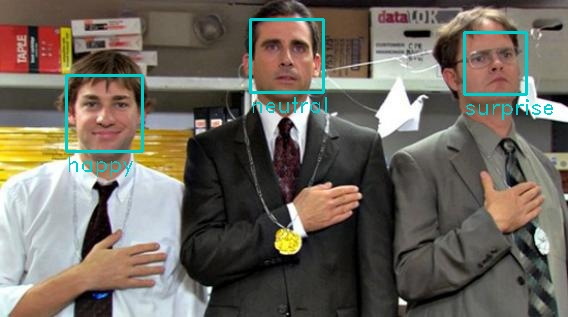

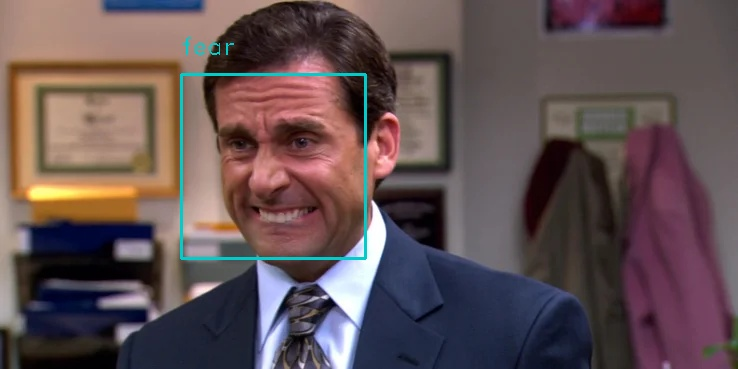

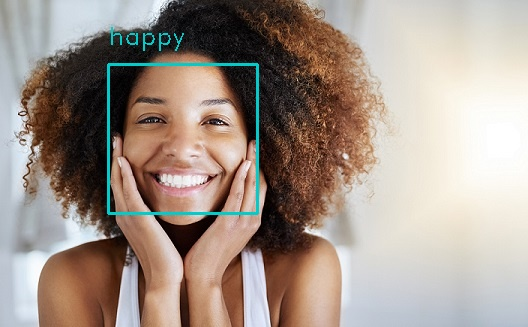

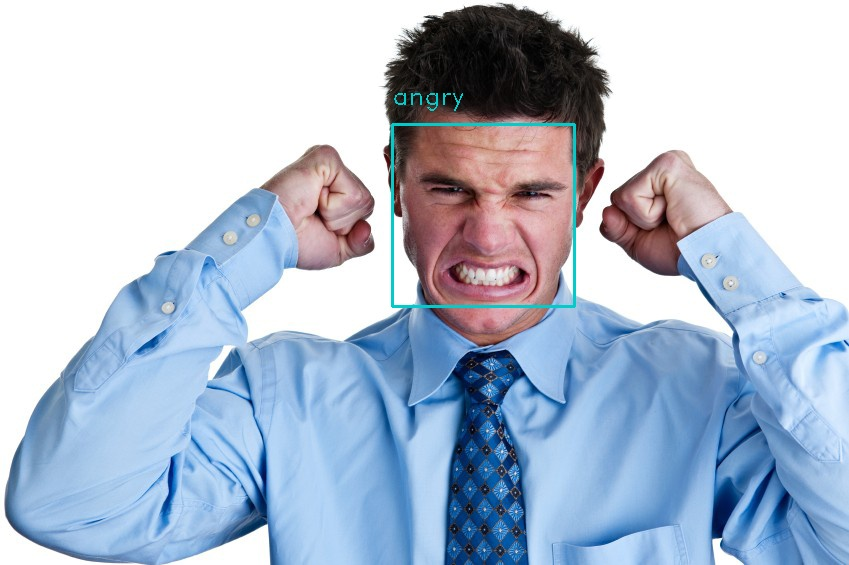

In [51]:
from IPython.display import Image, display

images = ['/content/test1.jpg',
          '/content/test2.jpg',
          '/content/test3.jpg',
          '/content/test4.jpg']

for image in images:
    display(Image(filename=image))

In [3]:
import numpy as np
import pickle
import pathlib
from keras_vggface.vggface import VGGFace
from os.path import dirname, basename
import os
import cv2
import random

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from keras_vggface.vggface import VGGFace
from keras_vggface import utils
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Dropout, Flatten, GlobalAveragePooling2D
from keras.optimizers import Adam, RMSprop

# from google.colab import drive
# drive.mount('/content/drive')

Using TensorFlow backend.


In [0]:
train_dir = pathlib.Path('images/train/')
test_dir = pathlib.Path('images/validation/')


def get_image_paths(image_dir):
    image_paths = list(image_dir.glob('*/*'))
    image_paths = [str(path) for path in image_paths]
    random.shuffle(image_paths)
    return image_paths


def save_pickle(file, filename):
    output = open(filename, 'wb')
    pickle.dump(file, output)
    output.close()

    
def load_pickle(filename):
    output = open(filename, 'rb')
    file = pickle.load(output)
    output.close()
    
    return file
  
  
def format_and_save_data():
    num_classes = 7
    
    train_image_paths = get_image_paths(train_dir)
    x_train = [cv2.imread(str(f)) for f in train_image_paths]
    save_pickle(x_train, 'x_train.pickle')
    
    test_image_paths = get_image_paths(test_dir)
    x_test = [cv2.imread(str(f)) for f in test_image_paths]
    save_pickle(x_test, 'x_test.pickle')
    
    y_train = [basename(dirname(f)) for f in train_image_paths]
    y_test = [basename(dirname(f)) for f in test_image_paths]
    
    label_encoder = LabelEncoder()
    y_train = label_encoder.fit_transform(y_train)
    y_test = label_encoder.fit_transform(y_test)
    y_train = np_utils.to_categorical(y_train, num_classes)
    y_test = np_utils.to_categorical(y_test, num_classes)
    save_pickle(label_encode, 'encoder.pickle')
    
    save_pickle(y_test, 'y_test.pickle') 
    save_pickle(y_train, 'y_train.pickle')

def load_data():    
    data_dir = '/content/drive/My Drive/data/'
    x_train = load_pickle(data_dir + 'x_train.pickle')
    y_train = load_pickle(data_dir + 'y_train.pickle')
    
    x_test = load_pickle(data_dir + 'x_test.pickle')
    y_test = load_pickle(data_dir + 'y_test.pickle')
    
    encoder = load_pickle(data_dir + 'encoder.pickle')
    return x_train, y_train, x_test, y_test, encoder

In [9]:
x_train, y_train, x_test, y_test, encoder = load_data()

train_samples = len(x_train)
x_train = np.stack(x_train).astype('float')

val_samples = len(x_test)
x_test = np.stack(x_test).astype('float')

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.20.3 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


The pretrained model used here is the Oxford VGGFace, trained on 2.6 million faces of 2622 people (https://www.robots.ox.ac.uk/~vgg/software/vgg_face/).

I used a keras implementation of the model thanks to this repository: https://github.com/rcmalli/keras-vggface

I was able to get a validation accuracy of 0.6606 and a training accuracy of 0.8480. The data is pretty overfitted, though higher rates of dropout and batch normalization did not help with accuracy 

This accuracy is in the top 5 of the kaggle leaderboard (test data is used for validation).

The associated paper mentions that human accuracy on the dataset is 65±5%. 

Surprisingly, unfreezing all the layers from the pretrained model led to a higher accuracy. The pretrained weights are not much help aside from saving computation time, even though the datasets are similar.


In [0]:
num_classes = 7

base_model = VGGFace(include_top = False, model = 'vgg16', weights = 'vggface', input_shape = (48, 48, 3))
 
model = Sequential()
model.add(base_model)

model.add(Flatten())
model.add(Dense(2048, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(2048, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(1024, activation="relu"))
model.add(Dropout(0.3))


model.add(Dense(num_classes, activation = 'softmax'))

model.summary()

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0001),
               metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.2, patience=3, min_lr=0.000001)
early_stop = EarlyStopping(monitor='val_acc', patience=7, restore_best_weights=True)
checkpoint = ModelCheckpoint(filepath='model17.hdf5', monitor='val_acc', verbose=1,save_best_only=True)

train_gen = ImageDataGenerator(
  rescale = 1./255,
  horizontal_flip = True,
  fill_mode = "nearest",
  rotation_range=20,
  width_shift_range = 0.15,
  height_shift_range=0.15)

val_gen = ImageDataGenerator(rescale = 1./255)

train_generator = train_gen.flow(x_train, y=y_train, batch_size=64, shuffle=True)
val_generator = val_gen.flow(x_test, y=y_test, batch_size=64, shuffle=True)

model.fit_generator(train_generator, epochs=100, steps_per_epoch = train_samples / 64, validation_data = val_generator, 
                        validation_steps = val_samples / 64, callbacks = [reduce_lr, early_stop, checkpoint], shuffle = True)

Given an image of a person, we can use face recogntion with opencv to grab the bounding box of a face, crop and preprocess the image and feed it into a saved model.

In [0]:
from google.colab.patches import cv2_imshow

model = load_model('/content/model.hdf5')

image = cv2.imread('/content/happy.jpg')
im_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

face_cascade = cv2.CascadeClassifier('/content/haarcascade_frontalface_default.xml')

faces = face_cascade.detectMultiScale(
    im_gray,
    scaleFactor=1.2,
    minNeighbors=5,
    minSize=(30, 30),
    flags = cv2.CASCADE_SCALE_IMAGE
)

for (x, y, w, h) in faces:
    # crop_img = img[y:y+h, x:x+w]
    face = image[y:y+h, x:x+w]
    
    face = cv2.resize(face, (48, 48), interpolation = cv2.INTER_AREA)
    face = np.expand_dims(face, axis=0)
    face = np.array(face, dtype=np.float64)
    face = utils.preprocess_input(face, version=1) # or version=2
  
    prediction = model.predict(face)
    pred_num = np.argmax(prediction)
    encoded = encoder.inverse_transform([pred_num])
    
    cv2.rectangle(image, (x, y), (x + w, y + h), (204, 204, 0), 2)
    cv2.putText(image, encoded[0], (x, y - 20), cv2.FONT_HERSHEY_DUPLEX, .8, (204, 204, 0), 1)
"""    
    x, y ------
    |          |
    |          |
    |          |
     ------x+w, y+h
"""
cv2.imwrite('/content/test.jpg', image)
cv2_imshow(image)